In [3]:
# from importlib import reload  

from tic_tac_toe import TicTacToe, plot_test_game
from agents import RandomAgent, TQAgent, RolloutAgent, MCTSAgent

import random
import numpy as np
from tqdm import tqdm
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set(rc={
    'figure.figsize': (15, 8),
    'legend.fontsize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16
})

SEED = 1337
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

## Random policy

In [4]:
def run_random_episode(env, agent, debug=False):
    env.reset()
    state, empty_cells, turn = env.getState()
    done = False
    while not done:
        action = agent.select_best_action(state)
        (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        if debug:
            env.printBoard()
            print(state, turn, reward)
    return reward

In [7]:
# env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
# run_random_episode(env, RandomAgent(), True)

-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
112111111 -1 0
-------------
|   |   | x | 
-------------
|   |   | o | 
-------------
|   |   |   | 
-------------
112110111 1 0
-------------
|   |   | x | 
-------------
|   |   | o | 
-------------
|   |   | x | 
-------------
112110112 -1 0
-------------
|   |   | x | 
-------------
|   |   | o | 
-------------
|   | o | x | 
-------------
112110102 1 0
-------------
|   |   | x | 
-------------
|   |   | o | 
-------------
| x | o | x | 
-------------
112110202 -1 0
-------------
|   |   | x | 
-------------
|   | o | o | 
-------------
| x | o | x | 
-------------
112100202 1 0
-------------
|   |   | x | 
-------------
| x | o | o | 
-------------
| x | o | x | 
-------------
112200202 -1 0
-------------
| o |   | x | 
-------------
| x | o | o | 
-------------
| x | o | x | 
-------------
012200202 1 0
-------------
| o | x | x | 
-------------
| x | o | o | 
-------------
| x 

0

In [6]:
crosses_win, naughts_win, draws = 0, 0, 0
N_EPISODES = 1000
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

for _ in range(N_EPISODES):
    reward = run_random_episode(env, RandomAgent())
    if reward == 1:
        crosses_win += 1
    elif reward == -1:
        naughts_win += 1
    else:
        draws += 1
print('Random policy stats')
print('Crosses winrate:', crosses_win / N_EPISODES)
print('Naughts winrate:', naughts_win / N_EPISODES)
print('Draws rate:', draws / N_EPISODES )
# crosses_win + naughts_win + draws == n_episodes

Random policy stats
Crosses winrate: 0.563
Naughts winrate: 0.3
Draws rate: 0.137


## Tabular Q-learning

In [8]:
def train_tq(env, x_agent, o_agent, n_episodes):
    # train tabular Q-agent against itself
    agents = {
            1: x_agent, -1: o_agent
        }
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        agents[1].curr_action, agents[-1].curr_action = None, None
        done = False
        
        # one episode
        while not done:
            action = agents[turn].select_action(state)
            agents[turn].update_Q(state, action, 0)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        agents[1].update_Q(state, action, reward)
        agents[-1].update_Q(state, action, reward)


def validate_tq(env, tq_agent, n_episodes):
    # validate against random
    if tq_agent.side == 'o':
        agents = { 
            1: RandomAgent(), -1: tq_agent
        }
    else:
        agents = {
            1: tq_agent, -1: RandomAgent()
        }
    all_rewards = []
    
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        done = False
        while not done:
            action = agents[turn].select_best_action(state)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        all_rewards.append(reward)
    
    return all_rewards

### 3x3 board

100%|██████████| 300/300 [02:29<00:00,  2.01it/s]


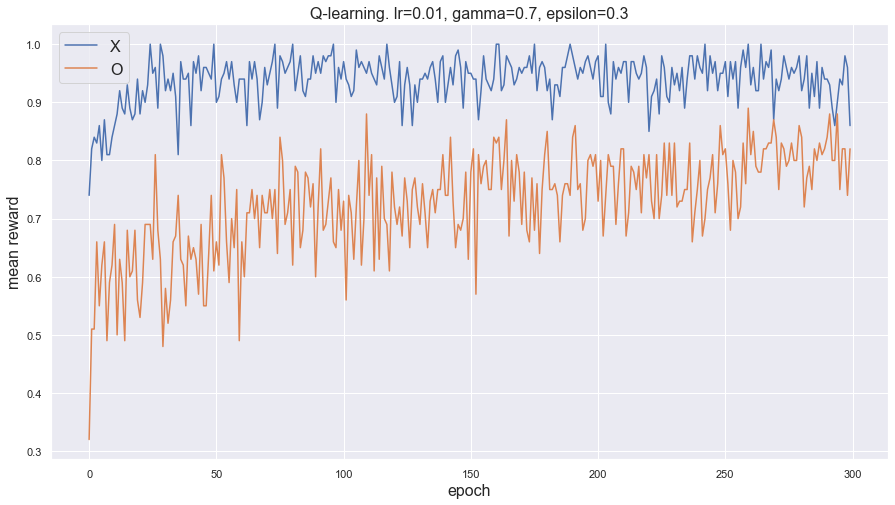

In [18]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()

# hyperparameters
LR = .01
GAMMA = .7
EPS = .3
# crosses agent
x_agent = TQAgent(len(state), LR, GAMMA, EPS, 'x')
# naughts agent
o_agent = TQAgent(len(state), LR, GAMMA, EPS, 'o')

# evaluate each agent every 1_000 episodes of training
N_EPOCHS = 300
x_rewards, o_rewards, x_means, o_means = [], [], [], []

for _ in tqdm(range(N_EPOCHS)):
    train_tq(env, x_agent, o_agent, 1_000)
    x_means.append(np.mean(validate_tq(env, x_agent, 100)))
    o_means.append(np.mean(validate_tq(env, o_agent, 100)))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'Q-learning. lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

С помощью табличного Q-обучения на доске 3х3 удалось получить хорошие стратегии для крестиков и ноликов 

### 4x4 board

100%|██████████| 300/300 [04:59<00:00,  1.00it/s]


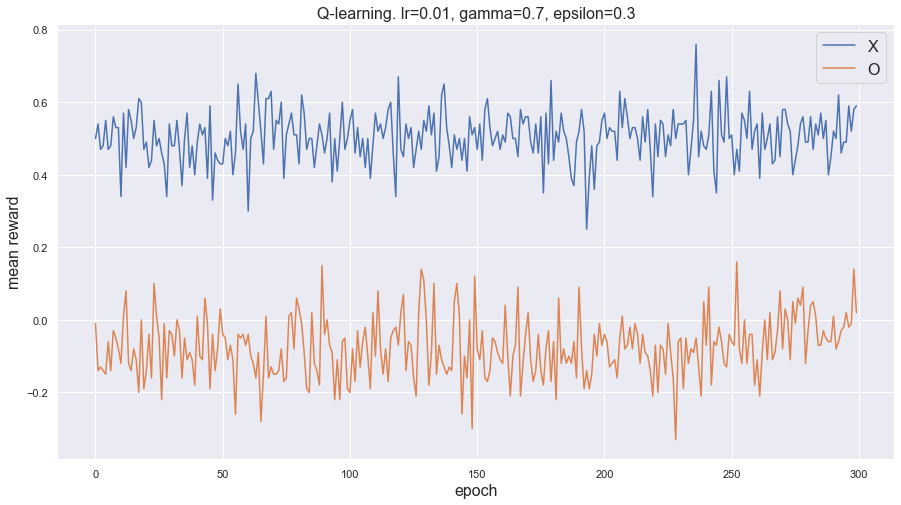

In [21]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
state, _, _ = env.getState()

# hyperparameters
LR = .01
GAMMA = .7
EPS = .3
# crosses agent
x_agent = TQAgent(len(state), LR, GAMMA, EPS, 'x')
# naughts agent
o_agent = TQAgent(len(state), LR, GAMMA, EPS, 'o')

# evaluate each agent every 1_000 episodes of training
N_EPOCHS = 300
x_rewards, o_rewards, x_means, o_means = [], [], [], []

for _ in tqdm(range(N_EPOCHS)):
    train_tq(env, x_agent, o_agent, 1_000)
    x_means.append(np.mean(validate_tq(env, x_agent, 100)))
    o_means.append(np.mean(validate_tq(env, o_agent, 100)))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'Q-learning. lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

На доске 4х4 дела обстоят хуже. С течением времени нет практически никаких улучшений. Возможно стоит попробовать на других гиперпараметрах и подождать схождения подольше.

## Rollouts on random agents

### 3x3 board

100%|██████████| 800/800 [01:22<00:00,  9.66it/s]


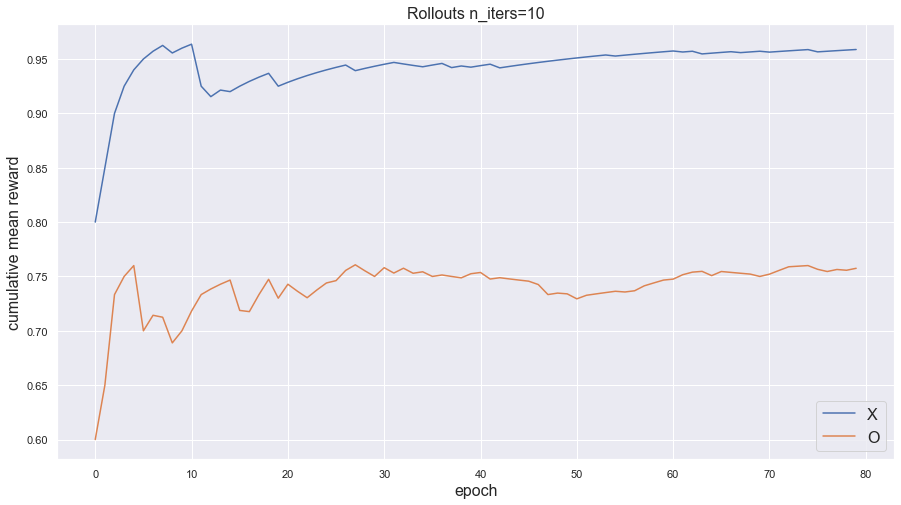

In [4]:
N_ITERS = 10
x_agent = RolloutAgent(TicTacToe(3, 3, 3), N_ITERS, 'x')
o_agent = RolloutAgent(TicTacToe(3, 3, 3), N_ITERS, 'o')
x_rewards, o_rewards, x_means, o_means = [], [], [], []
N_EPOCHS = 800

for i in tqdm(range(N_EPOCHS)):
    x_rewards.append(x_agent.run_episode())
    o_rewards.append(o_agent.run_episode())
    if (i + 1) % 10 == 0:
        x_means.append(np.mean(x_rewards))
        o_means.append(np.mean(o_rewards))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'Rollouts n_iters={N_ITERS}')
plt.xlabel('epoch')
plt.ylabel('cumulative mean reward')
plt.legend()
plt.show()

По причине того, что крестики-нолики на доске 3х3 - это довольно простая игра, даже такой бесхитростный алгоритм, как роллауты быстро находит оптимальную стратегию для крестиков, но чуть хуже чувствует себя с ноликами. Здесь может помочь увеличение параметра **N_ITERS**

### 4x4 board

100%|██████████| 500/500 [51:57<00:00,  6.23s/it]    


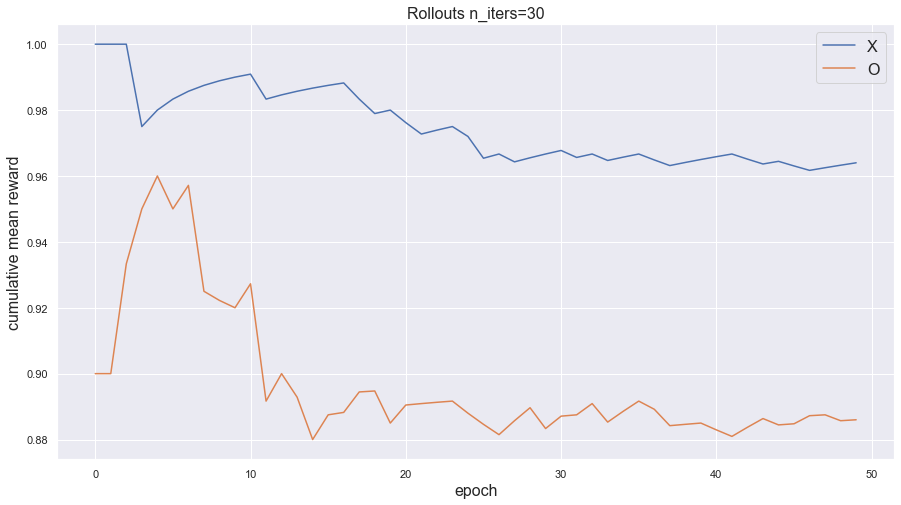

In [11]:
N_ITERS = 30
x_agent = RolloutAgent(TicTacToe(4, 4, 4), N_ITERS, 'x')
o_agent = RolloutAgent(TicTacToe(4, 4, 4), N_ITERS, 'o')
x_rewards, o_rewards, x_means, o_means = [], [], [], []
N_EPOCHS = 500

for i in tqdm(range(N_EPOCHS)):
    x_rewards.append(x_agent.run_episode())
    o_rewards.append(o_agent.run_episode())
    if (i + 1) % 10 == 0:
        x_means.append(np.mean(x_rewards))
        o_means.append(np.mean(o_rewards))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'Rollouts n_iters={N_ITERS}')
plt.xlabel('epoch')
plt.ylabel('cumulative mean reward')
plt.legend()
plt.show()

На доске 4х4 роллауты тоже справились очень хорошо с увеличенным параметром **N_ITERS**

## Monte Carlo Tree Search

### 3x3 board

100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


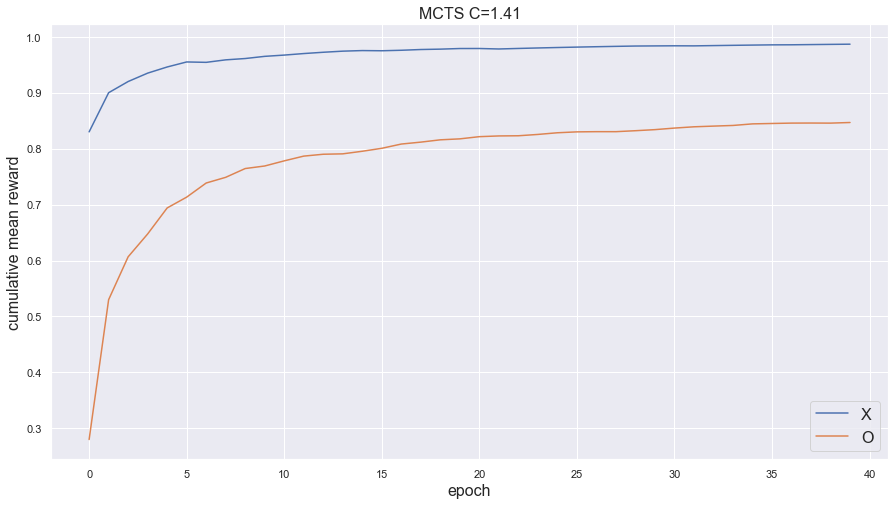

In [7]:
N_EPOCHS = 40
EXPLORATION_CONST = math.sqrt(2)

x_agent = MCTSAgent(TicTacToe(3, 3, 3), 'x', EXPLORATION_CONST)
o_agent = MCTSAgent(TicTacToe(3, 3, 3), 'o', EXPLORATION_CONST)
x_rewards, x_means, o_rewards, o_means = [], [], [], []

for _ in tqdm(range(N_EPOCHS)):
    x_agent.learn(1_000)
    o_agent.learn(1_000)
    x_rewards.append(x_agent.validate(100))
    o_rewards.append(o_agent.validate(100))
    x_means.append(np.mean(x_rewards))
    o_means.append(np.mean(o_rewards))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'MCTS C={round(EXPLORATION_CONST,2)}')
plt.xlabel('epoch')
plt.ylabel('cumulative mean reward')
plt.legend()
plt.show()

MCTS на доске 3х3 почти идеально сошелся к оптимуму, причем крайне быстро 

### 4x4 board

100%|██████████| 340/340 [1:12:46<00:00, 12.84s/it]   


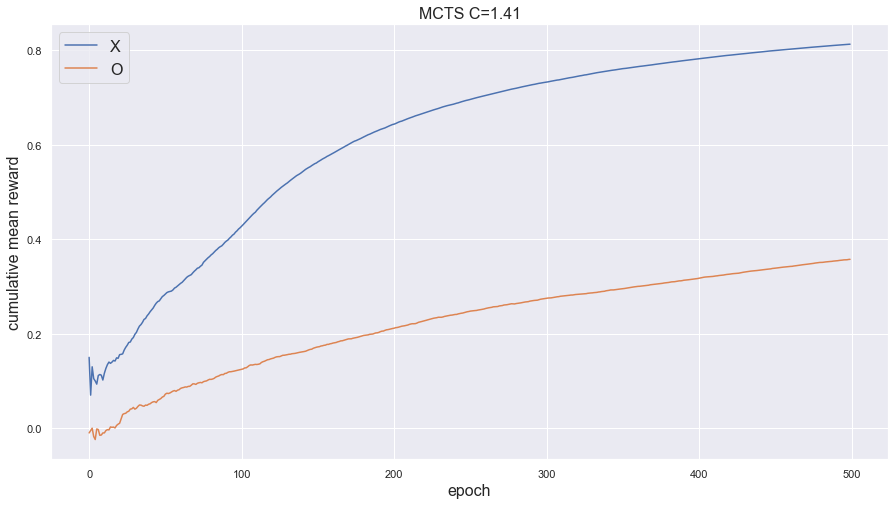

In [14]:
N_EPOCHS = 500
EXPLORATION_CONST = math.sqrt(2)

x_agent = MCTSAgent(TicTacToe(4, 4, 4), 'x', EXPLORATION_CONST)
o_agent = MCTSAgent(TicTacToe(4, 4, 4), 'o', EXPLORATION_CONST)
x_rewards, x_means, o_rewards, o_means = [], [], [], []

for _ in tqdm(range(N_EPOCHS)):
    x_agent.learn(1_000)
    o_agent.learn(1_000)
    x_rewards.append(x_agent.validate(100))
    o_rewards.append(o_agent.validate(100))
    x_means.append(np.mean(x_rewards))
    o_means.append(np.mean(o_rewards))

plt.plot(x_means, label='X')
plt.plot(o_means, label='O')
plt.title(f'MCTS C={round(EXPLORATION_CONST,2)}')
plt.xlabel('epoch')
plt.ylabel('cumulative mean reward')
plt.legend()
plt.show()

На доске 4х4 почему-то сходятся только крестики, и не к идеальной стратегии. Хотя у ноликов тоже есть некоторый тренд к улучшению на более длинной дистанции, возможно имеет смысл подождать чуть дольше и поэкспериментировать с другим параметром **EXPLORATION_CONST**